# Predicting Length-of-Stay at time of Hospital admission

In this section I'll walkthrough the implementation and selection of the supervised learning prediction model using the Scikit-Learn machine learning library.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns


In [2]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid

<Figure size 1008x504 with 0 Axes>

The mimic_los_cleanup performs all of the above data cleanup and feature engineering steps.

In [3]:
df_clean=pd.read_csv("clean_data/clean_data.csv")  
# Remove column name 'age'
#df_clean.drop(['age'], axis = 1)

In [4]:
actual_median_los=6.5628472222222225
actual_mean_los=10.134654296817752


In [5]:
df_clean = df_clean.iloc[: , 1:]

In [6]:
df_clean.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53104 entries, 0 to 53103
Data columns (total 61 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LOS                         53104 non-null  float64
 1   blood                       53104 non-null  int64  
 2   circulatory                 53104 non-null  int64  
 3   congenital                  53104 non-null  int64  
 4   digestive                   53104 non-null  int64  
 5   endocrine                   53104 non-null  int64  
 6   genitourinary               53104 non-null  int64  
 7   infectious                  53104 non-null  int64  
 8   injury                      53104 non-null  int64  
 9   mental                      53104 non-null  int64  
 10  misc                        53104 non-null  int64  
 11  muscular                    53104 non-null  int64  
 12  neoplasms                   53104 non-null  int64  
 13  nervous                     531

In [7]:
# Check for any remaining NaNs
df_clean.isnull().values.sum()

0

# Length-of-Stay Prediction Model

## Model Implementation

To implement the prediction model, I split the LOS target variable and features into training and test sets at an 80:20 ratio using the scikit-learn train_test_split function. Using the training set, I'll fit five different regression models (from the scikit-learn library) using default settings to see what the R2 score comparison looked like.

In [8]:
# Target Variable (Length-of-Stay)
LOS = df_clean['LOS']
# Prediction Features
features = df_clean.drop(columns=['LOS'])

In [9]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 42483 samples.
Testing set has 10621 samples.


In [10]:
# Regression models for comparison
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.


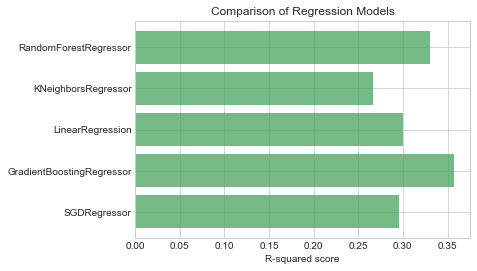

In [11]:
# R2 score results

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots()


ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
fig.savefig('images/compare_models.png', bbox_inches = 'tight')

The GradientBoostingRegressor took the win with an R2 score of ~36% so I decided to focus on refining this particular model. 

In [12]:
# GradientBoostingRegressor will be used as the LOS prediction model
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.357191


##  Model Refinement

The GradientBoostingRegressor performed well versus the other regression model. To refine the GradientBoostingRegressor model, I used the GridSearchCV function from scikit-learn to test out various permutations of parameters such as n_estimators, max_depth, and loss. The best estimator result from GridSearchCV was n_estimators=200, max_depth=4, and loss=l

In [13]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 42)

#Set the parameters by cross-validation
#tuned_parameters = [{'n_estimators': [100, 200, 300],
#                     'max_depth' : [2, 3, 4, None],
#                     'loss': ['ls', 'lad', 'huber']}]
    
tuned_parameters = [{'n_estimators': [200, 300],
                     'max_depth' : [3, 4],
                     'loss': ['ls', 'lad']}]
   


# create and fit a ridge regression model, testing each alpha
reg_model = GradientBoostingRegressor()  
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

0.4116283380149476
GradientBoostingRegressor(n_estimators=300)


In [14]:
#reg_model = GradientBoostingRegressor(n_estimators = 200, max_depth=4, random_state=0)   
#reg_model.fit(X_train, y_train)
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))

Optimized R2 score is: 0.376913


In [15]:
print('Model refinement improved R2 score by {:.4f}'.format(r2_optimized-r2_not_refined))

Model refinement improved R2 score by 0.0197


# Results

In [16]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

#feature_imp.head(20)

In [17]:
feature_imp.index[0:10].tolist()

['prenatal',
 'respiratory',
 'infectious',
 'nervous',
 'digestive',
 'injury',
 'skin',
 'congenital',
 'genitourinary',
 'circulatory']

##  Feature Importance

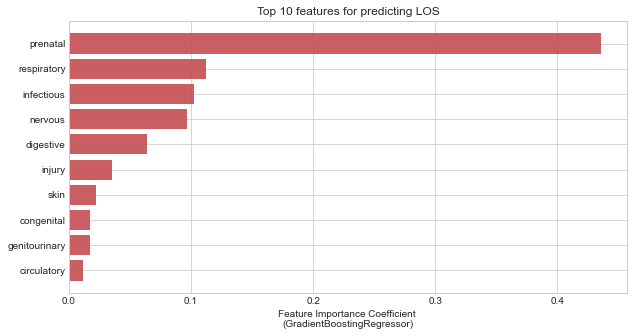

In [18]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 5))

plt.style.use('seaborn-whitegrid')
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10], 
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top 10 features for predicting LOS")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()
fig.savefig('images/feature_importance.png', bbox_inches = 'tight')

In [19]:
#LOS1= pd.DataFrame(df_clean['LOS'],columns=['LOS']).sort_values('LOS', ascending=False)
#LOS_a=LOS1['LOS'].values
#LOS_a.tolist()

In [20]:
LOS_a1 = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['LOS']).sort_values('LOS', ascending=False)
LOS_p1 = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_test.columns,
                                   columns=['LOS']).sort_values('LOS', ascending=False)
LOS_a2=LOS_a1['LOS'].mean
LOS_p2=LOS_p1['LOS'].mean

In [21]:
#LOS_a2.tolist()

In [22]:
#LOS_p2.tolist()

In [23]:
# LoS_Predictions	Testing set with the predicted dates of the two trained models for discharge 
# LoS	 Analytical data set: cleaned data with new features

#LOS_actual=LOS_a2 #.tolist()
#LOS_predict=LOS_p2 #.tolist()

In [24]:
y_test_preds = reg_model.predict(X_test)

ml_count, md_count, avg_count  = 0, 0, 0
ml_days, md_days, avg_days  = 0, 0, 0
ml_days_rms, md_days_rms, avg_days_rms  = 0, 0, 0

for i in range(y_test_preds.shape[0]):
    ml_model = abs(y_test_preds[i] - y_test[i])
    median_model = abs(actual_median_los - y_test[i])
    average_model = abs(actual_avg_los - y_test[i])
    
    ml_days += ml_model
    md_days += median_model
    avg_days += average_model
    
    ml_model_rms = (y_test_preds[i] - y_test[i])**2
    median_model_rms = (actual_median_los - y_test[i])**2
    average_model_rms = (actual_avg_los - y_test[i])**2
    
    ml_days_rms += ml_model_rms
    md_days_rms += median_model_rms
    avg_days_rms += average_model_rms

print("Prediction Model days {}".format(ml_days/y_test_preds.shape[0]))
print("Median Model days {}".format(md_days/y_test_preds.shape[0]))
print("Average Model days {}".format(avg_days/y_test_preds.shape[0]))

print("Prediction Model RMS {}".format((ml_days_rms**0.5)/y_test_preds.shape[0]))
print("Median Model RMS {}".format((md_days_rms**0.5)/y_test_preds.shape[0]))
print("Average Model RMS {}".format((avg_days_rms**0.5)/y_test_preds.shape[0]))

NotFittedError: This GradientBoostingRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Acknowledgments

MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35.<br>
Available from: http://www.nature.com/articles/sdata201635

I found these resources particularly helpful for this project:

- https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
- https://matplotlib.org/examples/api/barchart_demo.html
- https://stackoverflow.com/questions/46168450/replace-specific-range-of-values-in-data-frame-pandas
- https://en.wikipedia.org/wiki/Root-mean-square_deviation
- https://en.wikipedia.org/wiki/Coefficient_of_determination
- https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/
- https://www.healthcatalyst.com/success_stories/reducing-length-of-stay-in-hospital
- http://bok.ahima.org/Pages/Long%20Term%20Care%20Guidelines%20TOC/Practice%20Guidelines/Reporting